In [45]:
%matplotlib notebook

In [46]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [47]:
line = xt.Line.from_json('pimms_00_optics.json')
tw = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/220 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [48]:
line.vars['kse1'] = 1
line.vars['kse2'] = -8

In [49]:
def characterize_phase_space_at_septum(line, num_turns=2000, plot=False):
    x = np.linspace(0, 2.5e-2, 20)
                                       
    # Localize transition between stable and unstable
    x_septum = 3.5e-2

    x_stable = 0
    x_unstable = 3e-2
    while x_unstable - x_stable > 1e-6:
        x_test = (x_stable + x_unstable) / 2
        p = line.build_particles(x=x_test, px=0)
        line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
        mon_test = line.record_last_track
        if (mon_test.x > x_septum).any():
            x_unstable = x_test
        else:
            x_stable = x_test 
    
    p = line.build_particles(x=[x_stable, x_unstable], px=0)
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    mon_separatrix = line.record_last_track
    nc_sep = tw.get_normalized_coordinates(mon_separatrix)                                
    

    z_triang = nc_sep.x_norm[0, :] + 1j * nc_sep.px_norm[0, :]
    r_triang = np.abs(z_triang)
    
    # height of separatrix
    h_separatrix = np.min(np.abs(r_triang))
    
    # Find fixed points
    i_fp1 = np.argmax(r_triang)
    z_fp1 = z_triang[i_fp1]
    r_fp1 = np.abs(z_fp1)

    mask_fp2 = np.abs(z_triang - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp2 = np.argmax(r_triang * mask_fp2)

    mask_fp3 = np.abs(z_triang - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp3 = np.argmax(r_triang * mask_fp3)

    x_norm_fp = np.array([nc_sep.x_norm[0, i_fp1],
                          nc_sep.x_norm[0, i_fp2],
                          nc_sep.x_norm[0, i_fp3]])
    px_norm_fp = np.array([nc_sep.px_norm[0, i_fp1],
                           nc_sep.px_norm[0, i_fp2],
                           nc_sep.px_norm[0, i_fp3]])

    # Measure slope of the separatrix at the semptum
    x_separ = mon_separatrix.x[1, :]
    px_separ = mon_separatrix.px[1, :]
    x_norm_separ = nc_sep.x_norm[1, :]
    px_norm_separ = nc_sep.px_norm[1, :]
    i_septum = np.argmin(np.abs(x_separ - x_septum))

    poly_sep = np.polyfit([x_separ[i_septum + 3], x_separ[i_septum - 3]],
                             [px_separ[i_septum + 3], px_separ[i_septum - 3]],
                              deg=1)
    slope_separatrix = poly_sep[0]

    if plot:
        particles = line.build_particles(x=x, px=0)
        line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
        mon = line.record_last_track
        nc = tw.get_normalized_coordinates(mon) 

        plt.figure(figsize=(10, 5))
        ax_geom = plt.subplot(1, 2, 1)
        plt.plot(mon.x.T, mon.px.T, '.', markersize=1, color='C0')
        plt.ylabel(r'$p_x$')
        plt.xlabel(r'$x$ [m]')
        plt.xlim(-5e-2, 5e-2)
        plt.ylim(-5e-3, 5e-3)
        ax_norm = plt.subplot(1, 2, 2)
        plt.plot(nc.x_norm.T * 1e3, nc.px_norm.T * 1e3,
                 '.', markersize=1, color='C0')
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
        plt.gca().set_aspect('equal', adjustable='datalim')

        plt.xlabel(r'$\hat{x}$ [$10^{-3}$]')
        plt.ylabel(r'$\hat{y}$ [$10^{-3}$]')

        # Plot separatrix
        ax_geom.plot(mon_separatrix.x[0, :], mon_separatrix.px[0, :], '.', color='C2')
        ax_geom.plot(mon_separatrix.x[1, :], mon_separatrix.px[1, :], '.', color='C1')
        ax_norm.plot(nc_sep.x_norm[0, :] * 1e3, nc_sep.px_norm[0, :] * 1e3, '.', color='C2')
        ax_norm.plot(nc_sep.x_norm[1, :] * 1e3, nc_sep.px_norm[1, :] * 1e3, '.', color='C1')
        ax_norm.plot(x_norm_fp*1e3, px_norm_fp*1e3, '*', markersize=10, color='k')

        x_plt = [x_septum - 1e-2, x_septum + 1e-2]
        ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k', linewidth=3)
                                       
    return {
        'h_separatrix': h_separatrix,
        'slope_at_septum': slope_separatrix,
        'x_norm_fp': x_norm_fp,
        'px_norm_fp': x_norm_fp
    }

In [50]:
%time characterize_phase_space_at_septum(line, num_turns=1000)

CPU times: user 796 ms, sys: 9.41 ms, total: 806 ms
Wall time: 802 ms


{'h_separatrix': 0.004085501235424226,
 'slope_at_septum': -0.056178432768639916,
 'x_norm_fp': array([-0.00487381, -0.00380129,  0.00774364]),
 'px_norm_fp': array([-0.00487381, -0.00380129,  0.00774364])}

<IPython.core.display.Javascript object>


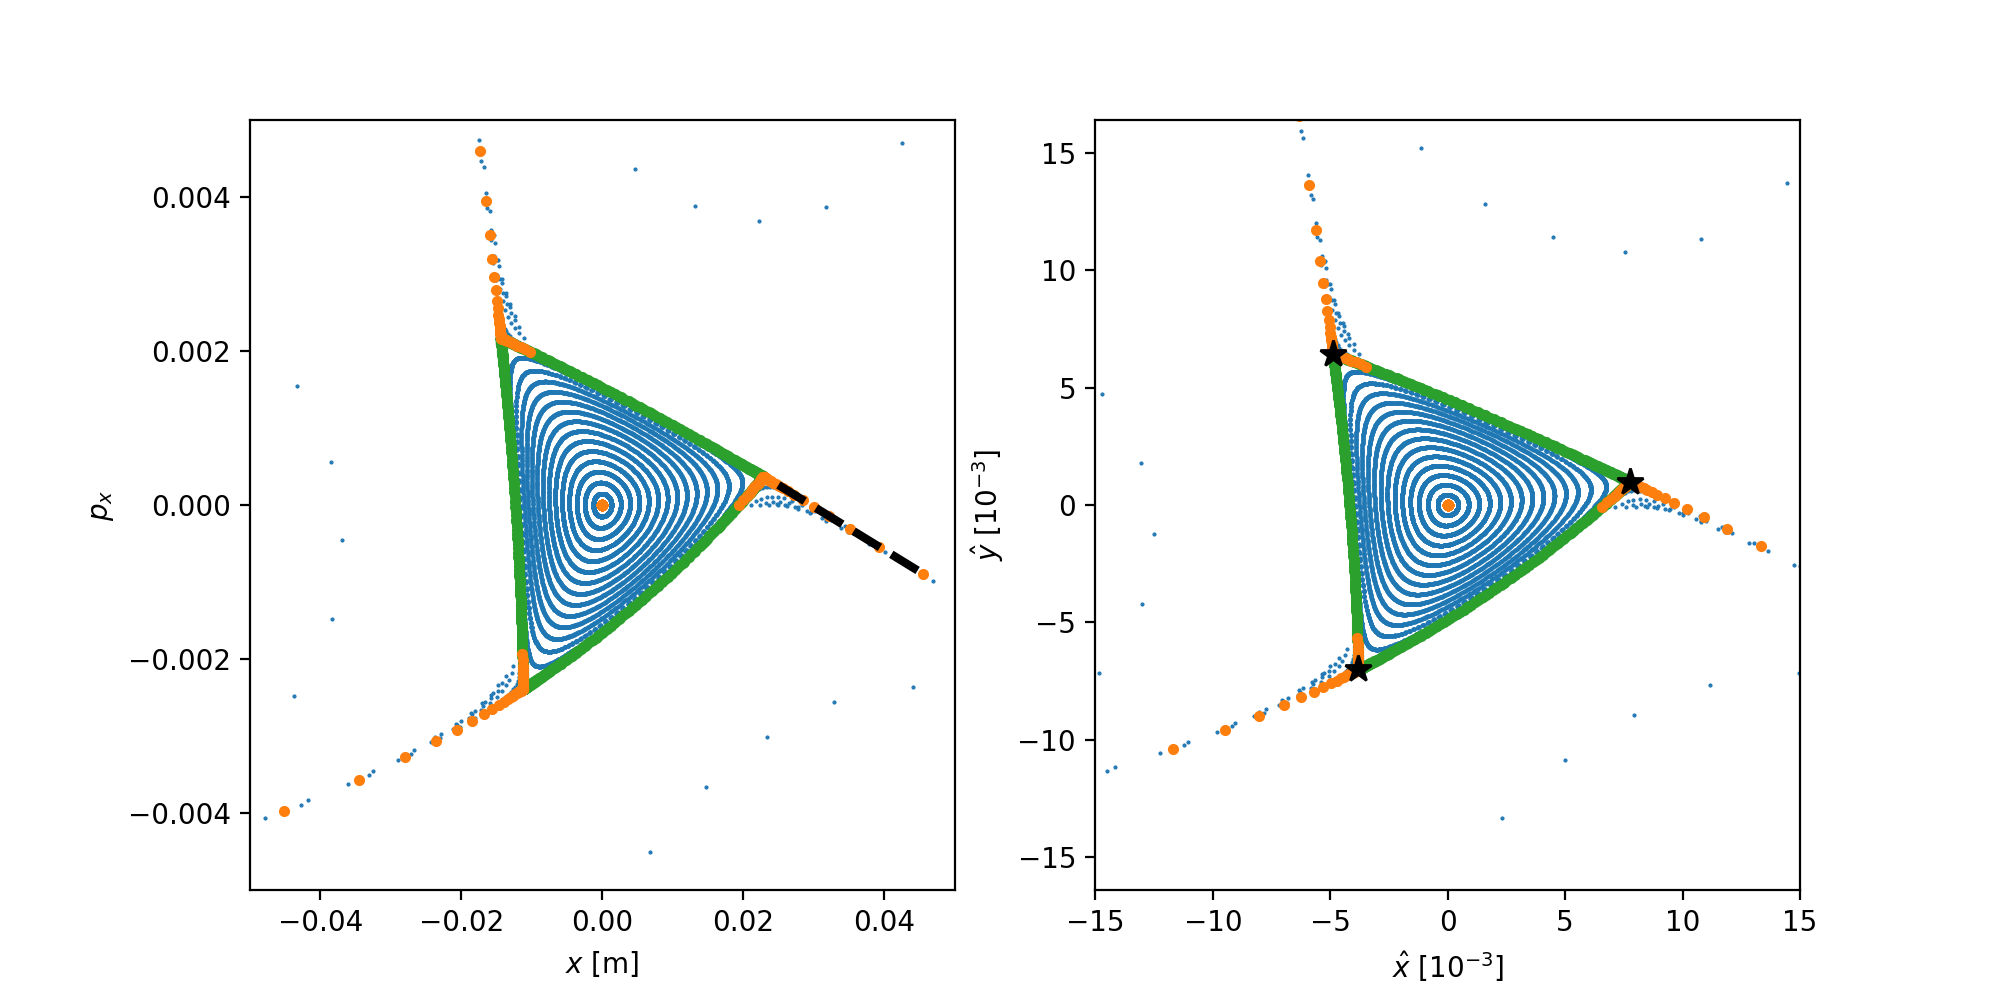

{'h_separatrix': 0.004085501235424226,
 'slope_at_septum': -0.056178432768639916,
 'x_norm_fp': array([-0.00487381, -0.00380129,  0.00774364]),
 'px_norm_fp': array([-0.00487381, -0.00380129,  0.00774364])}

In [51]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [56]:
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out

In [57]:
action = ActionSeparatrix(line)

In [58]:
action.run()

{'h_separatrix': 0.004084825781998476,
 'slope_at_septum': -0.056178432768639916,
 'x_norm_fp': array([-0.00487381, -0.00380129,  0.00774359]),
 'px_norm_fp': array([-0.00487381, -0.00380129,  0.00774359])}

In [65]:
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, tag='resonance',
                     limits=[-10, 10]),
    targets=[
        action.target('h_separatrix', 4e-3, tol=1e-4, weight=1),
        action.target('slope_at_septum', 0.05, tol=0.001)
    ]
)

In [66]:
opt.target_status()

Target status:                  
id state tag tol_met     residue current_val target_val description                                 
 0 ON           True -1.4391e-05  0.00398561      0.004 'h_separatrix', val=0.004, tol=0.0001, w ...
 1 ON          False  -0.0376227   0.0123773       0.05 'slope_at_septum', val=0.05, tol=0.001,  ...


In [ ]:
def err_fun(x):
    out = opt._err(x, check_limits=False)
    print(f'x = {x}, out = {out}')
    return out

bounds = np.array([vv.limits for vv in opt._err.vary])
opt._err.return_scalar = True
import pybobyqa
soln = pybobyqa.solve(err_fun, x0=opt.log().vary[0, :], bounds=bounds.T,
            rhobeg=10, rhoend=1e-3, maxfun=60, objfun_has_noise=True,
            seek_global_minimum=True)
err_fun(soln.x) # set it to the best solution
opt.tag('pybobyqa')
opt.target_status()

x = [ 7.7713889  -1.65951703], out = 0.0014154701379237478
x = [10.         -1.65951703], out = 0.0016697273806673318
x = [7.7713889  8.34048297], out = 0.0006301356072227868
x = [-2.2286111  -1.65951703], out = 495.06385801447146
x = [  7.7713889 -10.       ], out = 0.006499287442757234
x = [10.          8.34048297], out = 0.01475656176930779
x = [ 8.88567557 -1.59724138], out = 0.0014921600533328036
x = [ 8.79301549 10.        ], out = 0.018806272121558637
x = [9.09981115 4.90808801], out = 0.000937804443525148
x = [ 5.98460893 10.        ], out = 0.07745951854020326
x = [ 7.39619422 10.        ], out = 0.0006902345341470803
x = [9.87621526 6.22925977], out = 0.0008053830560737609
x = [8.74177841 6.94634291], out = 0.014494063202990501
x = [8.62326321 8.59896797], out = 0.0008500325792462284
x = [7.91988974 7.91293386], out = 0.0009042468019031331
x = [8.2123642  8.30388033], out = 0.0008324331024824666
x = [7.06476871 8.06676732], out = 0.0006981780151285598
x = [7.31006619 7.790429

In [ ]:
opt._err.return_scalar = False
opt.step()

In [20]:
opt.target_status()

Target status:                   
id state tag tol_met     residue current_val target_val description                                 
 0 ON           True 9.15959e-06  0.00400916      0.004 'h_separatrix', val=0.004, tol=0.0001, w ...
 1 ON           True  0.00448258   0.0544826       0.05 'slope_at_septum', val=0.05, tol=0.01, w ...


In [21]:
opt.vary_status()

Vary status:                 
id state tag       name lower_limit current_val upper_limit val_at_iter_0 step weight
 0 ON    resonance kse1         -10   0.0110037          10             1  0.5      1
 1 ON    resonance kse2         -10     7.50208          10            -8  0.5      1


<IPython.core.display.Javascript object>


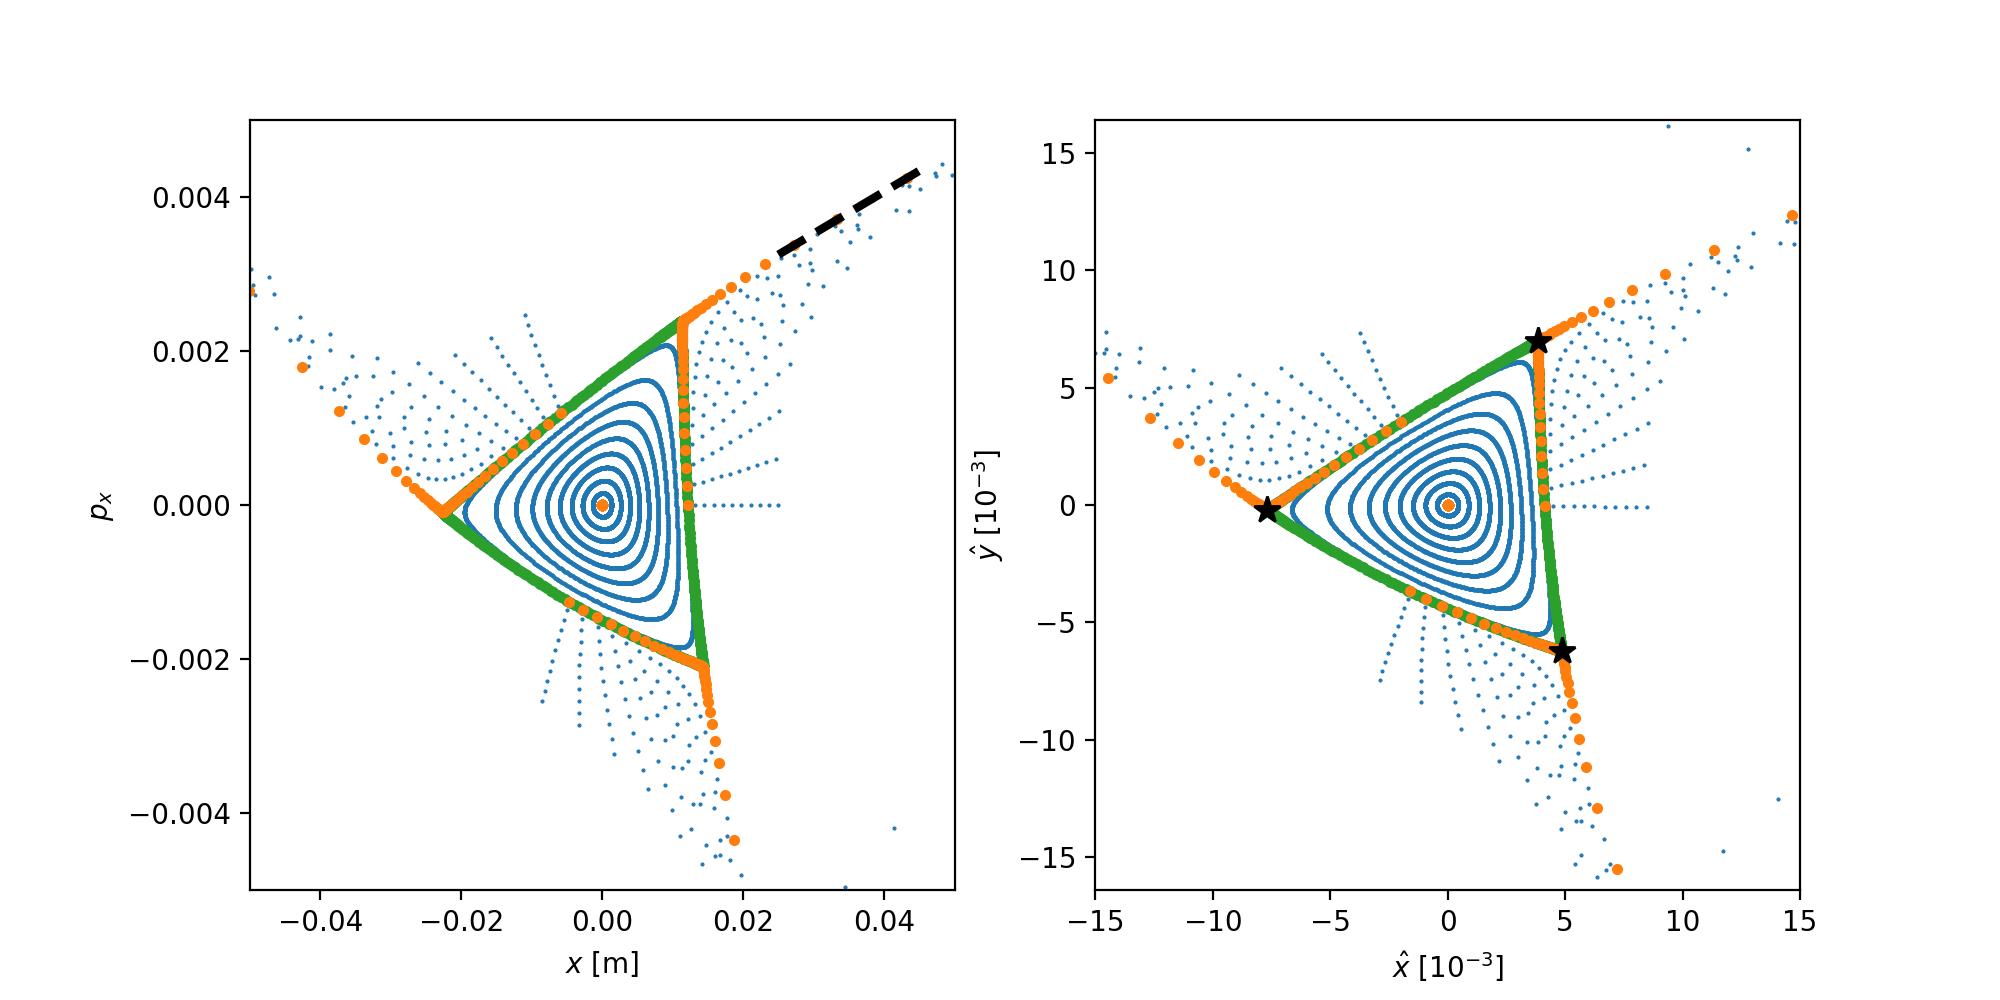

{'h_separatrix': 0.004009469975579173,
 'slope_at_septum': 0.054482575493917766,
 'x_norm_fp': array([ 0.00384432, -0.007679  ,  0.00485333]),
 'px_norm_fp': array([ 0.00384432, -0.007679  ,  0.00485333])}

In [22]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)